In [47]:
from typing import Tuple, Optional
from data.hysteresis import hysteresis_ode
from data.utils import _load_wrapper
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import torch

from scipy.integrate import solve_ivp

In [48]:
def simulate_steady_state(
    lam_values, 
    x0, 
    t_span:Tuple[float, float],
    t_eval: Optional[np.ndarray] = None,
    show_progress: bool = True,
    device:str = 'cpu'
)-> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    lam_values: control params 
    x0: initial state observation
    t_span: start and stop time of ode solution 
    t_eval: Points at which to save results. Default is end of t_span.
    show_progress: Show progress bar (tqdm)
    
    """
    wrapper = _load_wrapper(show_progress)

    x_curr = np.array([x0])
    
    if t_eval is None:
        t_eval = np.array([t_span[-1]])
    
    for idx, lam in enumerate(wrapper(lam_values)):
        sol = solve_ivp(
            hysteresis_ode, 
            t_span=t_span, 
            y0=x_curr, 
            args=(lam,), 
            t_eval=t_eval
        )

        x_curr = sol.y[:, -1]  # final value

        lam_i = np.array([lam]*len(t_eval))
        
        if idx == 0:
            x_vals = sol.y
            lam_vals = lam_i
            t_vals = t_eval
        
        else:
            x_vals = np.hstack((x_vals, sol.y[:,1:]))
            lam_vals = np.hstack((lam_vals,lam_i[1:]))
            t_vals = np.hstack((t_vals,t_eval[1:] + t_eval[-1]*idx))

    x_vals = torch.tensor(x_vals, dtype=torch.float32,device=device)
    lam_vals = torch.tensor(lam_vals, dtype=torch.float32,device=device)    
    t_vals = torch.tensor(t_vals, dtype=torch.float32,device=device)
    return x_vals, lam_vals, t_vals


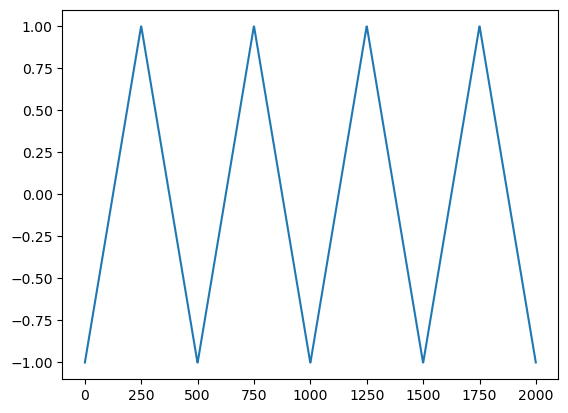

In [49]:
lam_start = -1 
lam_end = 1

n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

lam = np.hstack((lam_increase,lam_decrease))
repeat = 2
for _ in range(repeat):
    lam = np.hstack((lam, lam))
plt.plot(lam)

In [50]:
t_eval = np.linspace(0,50,101)
# t_eval = None
x0s = np.linspace(-1.6, -1., 11)
Xs = []
for x0 in tqdm(x0s):
    Xi, lams, T = simulate_steady_state(lam, x0, t_span=[0,50], t_eval=t_eval, show_progress=False)
    Xs.append(Xi)
Xs = torch.cat(Xs)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

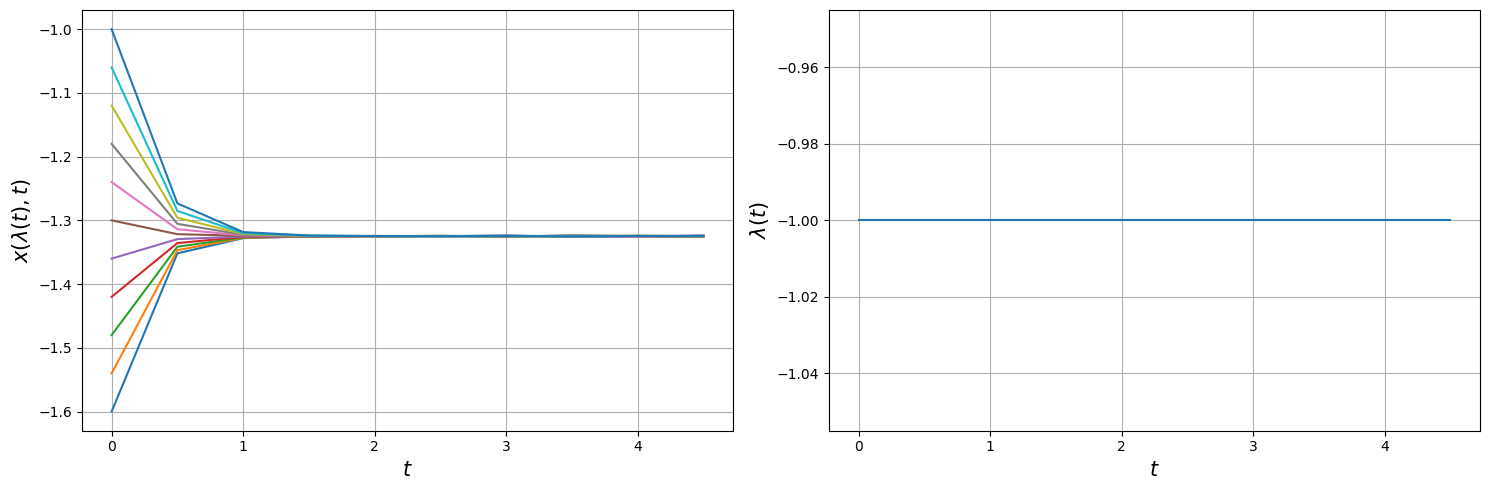

In [51]:
cutoff = 10
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,5))
for idx, x0 in enumerate(tqdm(x0s)):
    ax1.plot(T[:cutoff], Xs[idx][0, :cutoff], label=rf"$x_0$ = {x0:.3f}")
ax1.set_xlabel(r"$t$", size=15)
ax1.set_ylabel(r"$x(\lambda(t),t)$",size=15)
# ax1.legend(prop={'family': 'serif'})
ax1.grid(True)
# ax1.set_yscale('log')
ax2.plot(T[:cutoff], lams[:cutoff])
ax2.grid(True)
ax2.set_xlabel(r"$t$", size=15)
ax2.set_ylabel(r"$\lambda(t)$",size=15)
plt.tight_layout()
# plt.savefig(f"x0_pertubations_{len(x0s)}.png")
# plt.savefig(f"x0_pertubations_{len(x0s)}.png")
plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

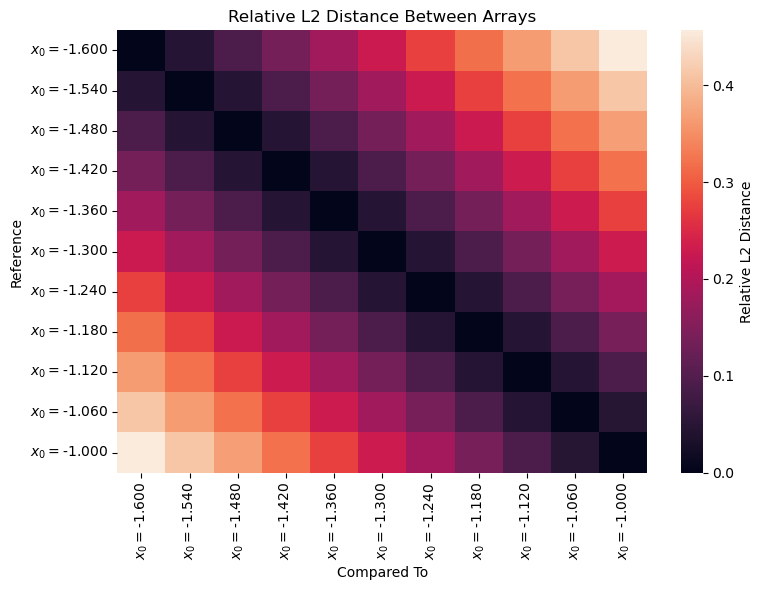

In [66]:
l2_rel_err = lambda x,y: np.linalg.norm(x-y) / np.var(x)
names = [rf"$x_0=${x0:.3f}" for x0 in x0s]
series = pd.Series(list(xi.numpy() for xi in Xs), index =names)
dist_df = pd.DataFrame(index=names, columns=names, dtype=float)
for i in tqdm(names):
    for j in names:
        dist_df.loc[i,j] = l2_rel_err(series[i], series[j])

fig, ax = plt.subplots(1,1, figsize = (8,6))
sns.heatmap(dist_df, annot=False, fmt=".4f", cmap="rocket", cbar_kws={'label': 'Relative L2 Distance'})
plt.title("Relative L2 Distance Between Arrays")
plt.xlabel("Compared To")
plt.ylabel("Reference")
plt.tight_layout()
# plt.savefig(f"l2_err_heatmap_x0_perturbations_{len(x0s)}_var.png")
plt.show()


tensor(0.)

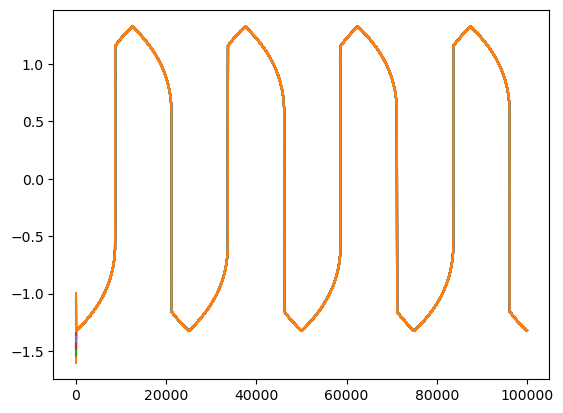

In [154]:
idx = np.arange(0,200001)
# print(idx)
a = Xs[idx]
b = Xs[idx]
plt.plot(T[idx],a)
plt.plot(T[idx],b)
torch.linalg.norm(a-b)

## update dataloader

In [101]:
import torch
import numpy as np
from stabnode.node import StabNODE, Felu, Gelu, set_global_seed, model_trainer
from torchdiffeq import odeint
import torch.nn as nn

from typing import Optional

In [6]:
set_global_seed(1234)

In [228]:
class TrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self, X, t, window_size:Optional[int]=None ):
        self.X = X              # shape [T_total, d]
        self.t = t              # shape [T_total]
        self.window_size = window_size

    def __len__(self):
        if self.window_size is None:
            return 1
        return len(self.X) - self.window_size

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(
                f"Index {idx} is out of bounds of dataset size: {self.__len__()}."
            )
        
        if self.window_size is None:
            return self.X, self.t, self.X[0]
        
        x0 = self.X[idx]                                          
        t_window = self.t[idx : idx + self.window_size]           
        x_window = self.X[idx : idx + self.window_size]           

        return x_window, t_window, x0

In [8]:
lam_start = -1 
lam_end = 1

x0=-1.3
n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

lam = np.hstack((lam_increase,lam_decrease))

t_eval = np.linspace(0,10,101)

In [9]:
Xi, lams, T = simulate_steady_state(lam, x0, t_span=[0,10], t_eval=t_eval, show_progress=True)

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
# def control_func(t:torch.tensor):
#     t = t.squeeze()
#     idx = np.where(np.isclose(T,t))[0]
#     return lams[idx]

from scipy.interpolate import interp1d

interp_lam = interp1d(T, lams.numpy(), axis=0, kind='linear')

def control_func(t: torch.Tensor):
    t_scalar = t.item()
    lam_t = torch.tensor(interp_lam(t_scalar), dtype=torch.float32)
    return lam_t.unsqueeze(0)


In [187]:
for idx, output in enumerate(train_loader):
    if idx == 0:
        a,b,c = output

In [189]:
a.shape

torch.Size([10, 100, 11])

In [239]:
train_dataset = TrajectoryDataset(Xs, T, window_size=100000)
len(train_dataset)

100001

In [248]:
train_dataset

In [210]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,shuffle=True) #[batch_size, n_samples_in_batch, dim]


In [212]:
count = 0
for a,b,c in train_loader:
    count +=1
    print(a.shape, b.shape,c.shape)
    b_time = b
print(count)

torch.Size([1, 200001, 11]) torch.Size([1, 200001]) torch.Size([1, 11])
1


In [182]:

print(len(train_dataset)//500)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

399


In [183]:
len(train_loader), len(train_dataset)

(19991, 199901)

In [171]:
Xs.shape

torch.Size([200001, 11])

In [35]:
f = Felu(dim_in=1,dim_out=1, hidden_dim=4)
g = Gelu(dim_in=2, dim_out=1, hidden_dim=2)
model = StabNODE(f,g).to("cpu")

In [45]:
# Sample data for testing
x0_batch = torch.tensor([0.5, 1.0, 1.5])  # Batch of initial conditions (1D array)
t_batch = torch.tensor([
    [0., 1., 2., 3.],
    [0., 0.5, 1., 1.5],
    [0., 0.75, 1.5, 2.25]
])  # Batch of t_spans (2D array)
t_batch = torch.tensor([
    [0., 1., 2., 3.],
    [0., 1., 2., 3.],
    [0., 1., 2., 3.]
])  # Batch of t_spans (2D array)

# Define a vectorized single-instance ODE integration using vmap
def single_instance_odeint(x0_i, t_i):
    y0_i = x0_i.reshape(-1, 1)  # Reshape initial condition into (N, D)
    x_pred_i = odeint(
        func=lambda t, x: model(t, x, control_func),  # ODE system dynamics
        y0=y0_i,
        t=t_i,
        method='rk4'
    )
    return x_pred_i.squeeze()

single_instance_odeint(x0_batch[0], t_batch[0])


tensor([0.5000, 0.4063, 0.3203, 0.2412], grad_fn=<SqueezeBackward0>)

In [46]:


# Apply torch.vmap to vectorize over x0_batch and t_batch
x_pred_all = torch.vmap(single_instance_odeint)(
    x0_batch, t_batch  # vmap aligns both batches element-wise
)

# Print results
print("Batch of predicted trajectories:")
print(x_pred_all)

RuntimeError: vmap: It looks like you're attempting to use a Tensor in some data-dependent control flow. We don't support that yet, please shout over at https://github.com/pytorch/functorch/issues/257 .

In [36]:
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = 0.1)
loss_criteria = nn.MSELoss()

model.train()

losses = []
for idx, (x0_batch, t_batch, x_true_batch) in enumerate(tqdm(train_loader)):
    opt.zero_grad()
    
    x_pred = []
    for x0_i, t_i in zip(x0_batch, t_batch):
        x_pred_i = odeint(
            func=lambda t, x: model(t, x, control_func),
            y0=x0_i.reshape(-1, 1),
            t=t_i,
            method='rk4'
        ).squeeze()
        x_pred.append(x_pred_i)

    x_pred = torch.stack(x_pred, dim=0) 

    loss = loss_criteria(x_pred.squeeze(), x_true_batch.squeeze())
    loss.backward()
    opt.step()

    losses.append(loss.item())

    # if idx == 0:
    #     x0s = x0_batch
    #     ts = t_batch
    #     xs = x_true_batch
    #     x_pred = odeint(
    #         func = lambda t, x: model(t,x, control_func),
    #         y0=x0s[0].reshape(-1,1),
    #         t=ts[0],
    #         method='rk4'
    #     ).squeeze()
        # print(xs[0].shape)
        # print(x_pred.shape)
        # print(torch.linalg.norm(x_pred - xs[0])/torch.linalg.norm(xs[0]))


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
losses

[1.1313954591751099,
 0.9778454899787903,
 0.7665290832519531,
 0.5117347240447998,
 0.283674031496048]

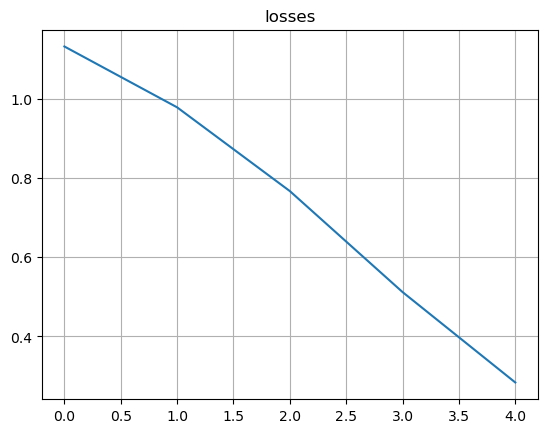

In [38]:
plt.plot(losses)
plt.title("losses")
plt.grid(True)
# plt.yscale('log')

In [ ]:
x_true_batch.shape, t_batch.shape, x0_batch.shape

(torch.Size([1, 100]), torch.Size([1, 100]), torch.Size([1]))

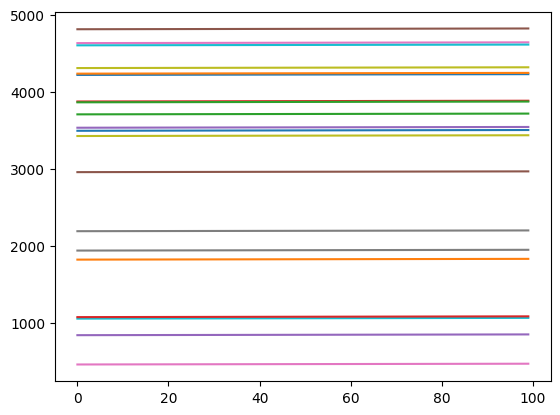

In [50]:
for ti in ts:
    plt.plot(ti)
# plt.yscale("log")
plt.show()

In [25]:
Xi[0,0]

tensor(-1.3000)

In [28]:
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = 0.1)
loss_criteria = nn.MSELoss()
model_trainer(model,opt,loss_criteria,x0=Xi[0,0].reshape(-1,1), tau_span = T, X_train = Xi, control =control_func, n_epochs=5, min_improvement=1e-4, patience=10, print_every=1,)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0: Loss = 0.5062, time = 116.0601
Epoch 1: Loss = 0.4388, time = 125.1359
Epoch 2: Loss = 0.3063, time = 130.0441
Epoch 3: Loss = 0.3102, time = 132.7801
Epoch 4: Loss = 0.2254, time = 134.8278


(StabNODE(
   (f): Felu(
     (network): Sequential(
       (0): Linear(in_features=1, out_features=4, bias=True)
       (1): ELU(alpha=1.0)
       (2): Linear(in_features=4, out_features=1, bias=True)
     )
   )
   (g): Gelu(
     (network): Sequential(
       (0): Linear(in_features=2, out_features=2, bias=True)
       (1): ELU(alpha=1.0)
       (2): Linear(in_features=2, out_features=1, bias=True)
       (3): Tanh()
     )
   )
 ),
 {'losses': [0.506229043006897,
   0.4388141930103302,
   0.3062892556190491,
   0.3102361261844635,
   0.2254309356212616],
  'times': [116.06011724472046,
   125.13592600822449,
   130.04410123825073,
   132.7801251411438,
   134.82779049873352],
  'stopping_criteria': 'max-epochs',
  'best_model_epoch': 4,
  'method_failures': [False, False, False, False, False],
  'patience_hist': [0, 0, 0, 1, 0]})

In [29]:
new_model, log = _

In [30]:
log

{'losses': [0.506229043006897,
  0.4388141930103302,
  0.3062892556190491,
  0.3102361261844635,
  0.2254309356212616],
 'times': [116.06011724472046,
  125.13592600822449,
  130.04410123825073,
  132.7801251411438,
  134.82779049873352],
 'stopping_criteria': 'max-epochs',
 'best_model_epoch': 4,
 'method_failures': [False, False, False, False, False],
 'patience_hist': [0, 0, 0, 1, 0]}